In [1]:
import sqlite3
import operator
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
from math import log

In [2]:
con = sqlite3.connect("data/gelbooru.db")
cur = con.cursor()
timeformat = "%Y-%m-%d %H:%M:%S"

In [3]:
## Create some useful views for the upcoming analysis.
# Create view that counts the tags grouped by its name.
cur.execute("CREATE TEMP VIEW IF NOT EXISTS tag_count AS " +
            "SELECT tag.id AS id, tag.name AS name, COUNT(tags.view) AS count " +
            "FROM tag JOIN tags ON tag.id = tags.tag " +
            "GROUP BY tag.name HAVING tag.name <> '1girl' AND tag.name <> 'solo'")

# General information

Tags used for searching: solo, 1girl, -comic, -4koma, -animated, -sound, -webm, -animated gif, -asian, -photo, -3d

## Some simple numbers

In [4]:
cur.execute("SELECT * FROM view ORDER BY id ASC LIMIT 1")
first_entry = cur.fetchone()
cur.execute("SELECT * FROM view ORDER BY id DESC LIMIT 1")
last_entry = cur.fetchone()
cur.execute("SELECT COUNT(*) FROM view")
total_count = cur.fetchone()[0]
cur.execute("SELECT COUNT(*) FROM tag")
tag_count = cur.fetchone()[0]

In [5]:
print("Id of first post: {} (from {})".format(first_entry[0], first_entry[1]))
print("Id of last post: {} (from {})".format(last_entry[0], last_entry[1]))
first_post_datetime = datetime.strptime(first_entry[1], timeformat)
last_post_datetime = datetime.strptime(last_entry[1], timeformat)
timedelta = last_post_datetime - first_post_datetime
print("Total count: {} (spanning {} days)".format(total_count, timedelta.days))
print("Number of tags: {}".format(tag_count))

Id of first post: 5 (from 2007-07-16 00:20:00)
Id of last post: 3150000 (from 2016-04-26 03:00:24)
Total count: 1212463 (spanning 3207 days)
Number of tags: 213432


In [6]:
id_diff_dict = dict()
last_row = 0
for row in cur.execute("SELECT id FROM view ORDER BY id ASC"):
    key = row[0] - last_row
    last_row = row[0]
    value = id_diff_dict.setdefault(key, 0)
    id_diff_dict[key] = value + 1

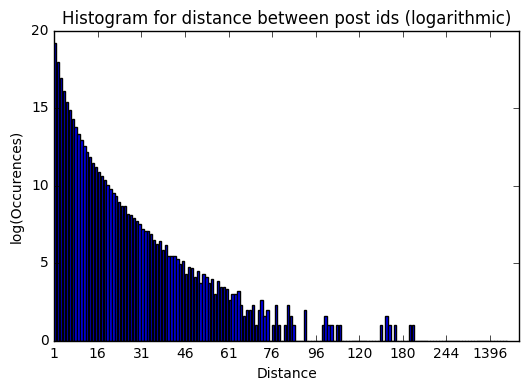

In [7]:
id_diff_x, id_diff_y = zip(*sorted(id_diff_dict.items(), key=operator.itemgetter(0)))
plt.bar(range(len(id_diff_x)), [log(y,2) for y in id_diff_y])
plt.xticks(range(0, len(id_diff_x), 15), id_diff_x[::15])
plt.title("Histogram for distance between post ids (logarithmic)")
plt.xlabel("Distance")
plt.ylabel("log(Occurences)")
plt.show()

Data seems rather consistent. No outliers.

In [8]:
cur.execute("SELECT rating.name, COUNT(view) FROM rates JOIN rating ON rates.rating = rating.id GROUP BY rating")
dist_ratings = cur.fetchall()

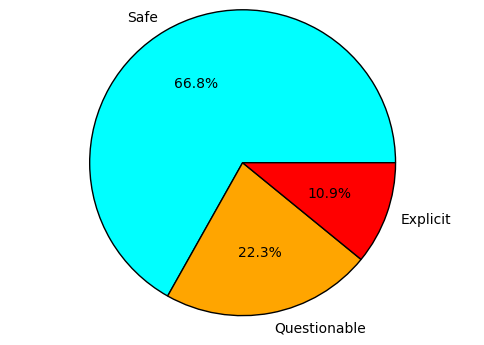

In [9]:
plt.pie([x[1] for x in dist_ratings], labels=[x[0] for x in dist_ratings], 
        colors=["cyan", "orange", "red"], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Wow. Seems like there is more safe content than I thought.

# Time series

Watch the data for every full month since the beginning. At the moment this is from Aug 2007 to Mar 2016.

In [10]:
total_months = (last_post_datetime.year - first_post_datetime.year - 1) * 12
total_months += last_post_datetime.month + (12 - first_post_datetime.month) + 1
first_id_of_month = np.empty(total_months, dtype=int)
year = 0
month = 0
index = 0
# Get the first id of each month.
for row in cur.execute("SELECT id, posted FROM view ORDER BY id ASC"):
    date = datetime.strptime(row[1], timeformat)
    if date.year > year:
        year = date.year
        month = 0
    if date.month > month:
        month = date.month
        first_id_of_month[index] = row[0]
        index += 1

In [11]:
# Count the number of uploads.
id_range = list(zip(first_id_of_month[0:-1], first_id_of_month[1:]))
count_per_month = []
for i in range(0, total_months - 1):
    ids = tuple((str(id) for id in id_range[i]))
    cur.execute("SELECT COUNT(*) FROM view WHERE id >= ? AND id < ?", ids)
    count_per_month.append(cur.fetchone())

In [12]:
# Count only safe uploads (no nudes etc.)
id_range = list(zip(first_id_of_month[0:-1], first_id_of_month[1:]))
count_per_month_safe = []
for i in range(0, total_months - 1):
    ids = tuple((str(id) for id in id_range[i]))
    cur.execute("SELECT COUNT(*) FROM view JOIN rates ON view.id = rates.view " +
                "WHERE view.id >= ? AND view.id < ? AND rates.rating = 1", ids)
    count_per_month_safe.append(cur.fetchone())

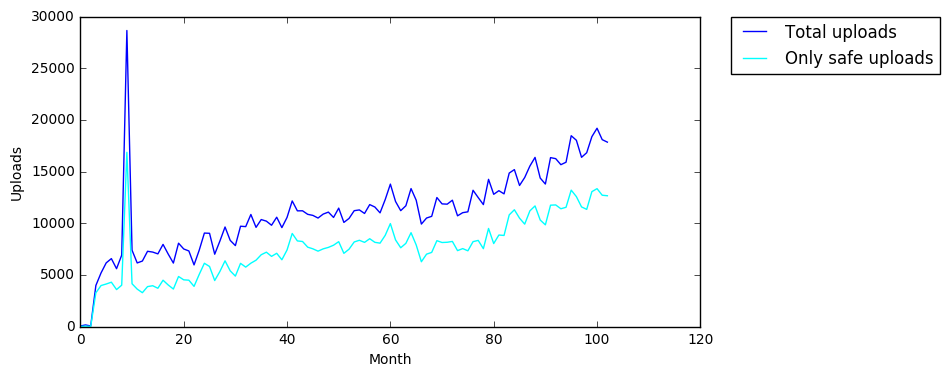

In [13]:
plt.figure(figsize=(8,4))
plt.plot(count_per_month[1:-1], label="Total uploads")
plt.plot(count_per_month_safe[1:-1], label="Only safe uploads", color="cyan")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Month")
plt.ylabel("Uploads")
plt.show()

Again, I think it is rather suprising how much the gap between total uploads and explicit content stays consistant.
I thought the gap would widen with the passing of time.

# Tag analysis

Goal: Find appropriate tags for automatic tagging with neural network.

In [14]:
cur.execute("SELECT tag_count.name, tag_count.count, tag_type.name " +
            "FROM tag_count JOIN categorizes ON tag_count.id = categorizes.tag " +
            "JOIN tag_type ON tag_type.id = categorizes.tag_type " +
            "WHERE count > 20000 ORDER BY count DESC")
top_tags = cur.fetchall()

In [15]:
print("{0:10} {1:>35} - {2:>6}".format("TYPE", "TAG NAME", "COUNT"))
print("-------------------------------------------------------")
for entry in top_tags:
    print("{0[2]:10} {0[0]:>35} - {0[1]:6d}".format(entry))
print("IN TOTAL:", len(top_tags), "TAGS")

TYPE                                  TAG NAME -  COUNT
-------------------------------------------------------
general                              long hair - 562353
general                                breasts - 474336
general                                  blush - 384920
general                                highres - 367095
general                                 female - 321347
general                                  smile - 309188
general                             short hair - 303731
general                      looking at viewer - 287483
copyright                               touhou - 267455
general                              blue eyes - 240885
general                             open mouth - 238594
general                                  skirt - 225126
general                             thighhighs - 218767
general                            blonde hair - 211997
general                               red eyes - 195450
general                             brown hair -

In [16]:
tag_count = np.array([entry[1] for entry in top_tags])
print("Mean:", np.mean(tag_count))
print("Standard derivation:", np.std(tag_count))

Mean: 72823.9223301
Standard derivation: 80927.2597798


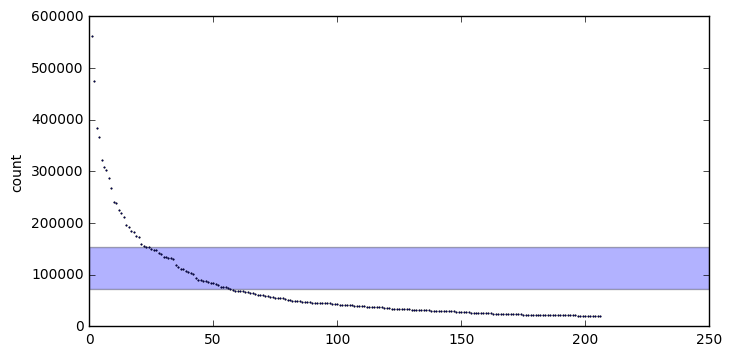

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(tag_count) + 1), tag_count, "bo", markersize=1)
plt.axhspan(np.mean(tag_count), np.mean(tag_count) + np.std(tag_count), alpha=0.3)
plt.ylabel("count")
plt.show()

Idea. Define categories by these tags:
* nude
* school uniform
* swimsuit
* japanese clothes
* dress
* shirt (for casual style)

*Check to what extend the id's for these tags are disjoint.*

Maybe use some additional features:
* loli
* cat ears

*These tags do not need to be disjoint.*

In [18]:
selected_tags = ("nude", "school uniform", "swimsuit", "japanese clothes", "dress", "shirt", "loli", "cat ears")

In [19]:
# Create views for the tags above.
for tag in selected_tags:
    cur.execute("CREATE TEMP VIEW IF NOT EXISTS {} AS ".format(tag.replace(" ", "_")) +
                "SELECT view FROM tags JOIN tag ON tags.tag = tag.id " +
                "WHERE tag.name = '{}'".format(tag))

In [20]:
# Count the specified tags.
print("{0:>20}  {1:>6}".format("Tag name", "Count"))
print("-" * 40)
selected_tag_count = dict()
for tag in selected_tags:
    cur.execute("SELECT COUNT(*) FROM {}".format(tag.replace(" ", "_")))
    selected_tag_count[tag] = cur.fetchone()[0]
    print("{0:>20}: {1:6d}".format(tag, selected_tag_count[tag]))

            Tag name   Count
----------------------------------------
                nude:  82642
      school uniform: 107694
            swimsuit:  86959
    japanese clothes:  50709
               dress: 147464
               shirt:  89891
                loli:  32649
            cat ears:  37377


In [21]:
# Count the specified tags with safe content.
print("{0:>20}  {1:>6} (SAFE)".format("Tag name", "Count"))
print("-" * 40)
selected_tag_count_safe = dict()
for tag in selected_tags:
    cur.execute("SELECT COUNT(*) FROM {0} JOIN rates ON {0}.view = rates.view ".format(tag.replace(" ", "_")) +
                "WHERE rates.rating = 1")
    selected_tag_count_safe[tag] = cur.fetchone()[0]
    print("{0:>20}: {1:6d}".format(tag, selected_tag_count_safe[tag]))

            Tag name   Count (SAFE)
----------------------------------------
                nude:   2317
      school uniform:  81192
            swimsuit:  50474
    japanese clothes:  40819
               dress: 126407
               shirt:  56457
                loli:      0
            cat ears:  24542


Seems like "loli" is used as some kind of fetish word here. (No safe loli pics! Whats wrong with the world?)

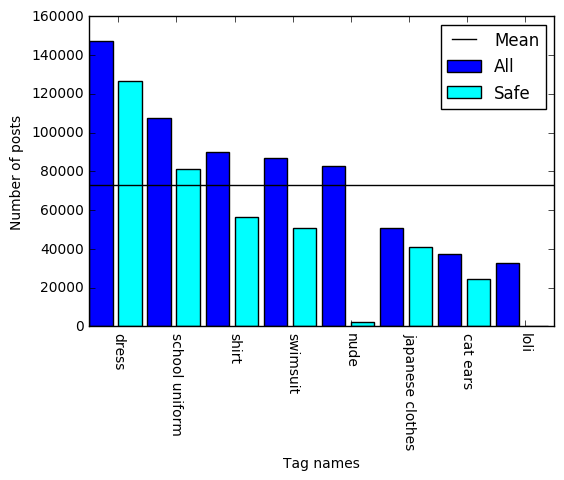

In [22]:
selected_tag_count_sorted = sorted(selected_tag_count.items(), key=operator.itemgetter(1), reverse=True)
x, y1 = zip(*selected_tag_count_sorted)
y2 = [selected_tag_count_safe[tag] for tag in x]
plt.bar(range(0, 2 * len(x), 2), y1)
plt.bar(range(1, 2 * len(x) + 1, 2), y2, color="cyan")
plt.axhline(np.mean(tag_count), color="black")
plt.xticks(range(1, 2 * len(x) + 1, 2), x, rotation=-90)
plt.xlabel("Tag names")
plt.ylabel("Number of posts")
plt.legend(["Mean", "All", "Safe"])
plt.show()

In [23]:
# Use ordered tags for further processing.
selected_tags = x
selected_tag_count = y1

In [24]:
# Check how disjoint the posts for these tags are.
disjoint_tags = [(x.replace(" ", "_"), y.replace(" ", "_"))
                 for x in selected_tags for y in selected_tags if x != y]
disjoint_tag_count = []
for tags in disjoint_tags:
    cur.execute("SELECT COUNT(*) FROM " +
                    "(SELECT view FROM {} ".format(tags[0]) + 
                     "INTERSECT " +
                     "SELECT view FROM {})".format(tags[1]))
    disjoint_tag_count.append(cur.fetchone()[0])

In [25]:
disjoint_tag_array = [disjoint_tag_count[i:][:len(selected_tags) - 1] 
                      for i in range(0, len(disjoint_tag_count), len(selected_tags) - 1)]
disjoint_tag_array = np.array(disjoint_tag_array)
tag1, tag2 = zip(*disjoint_tags)

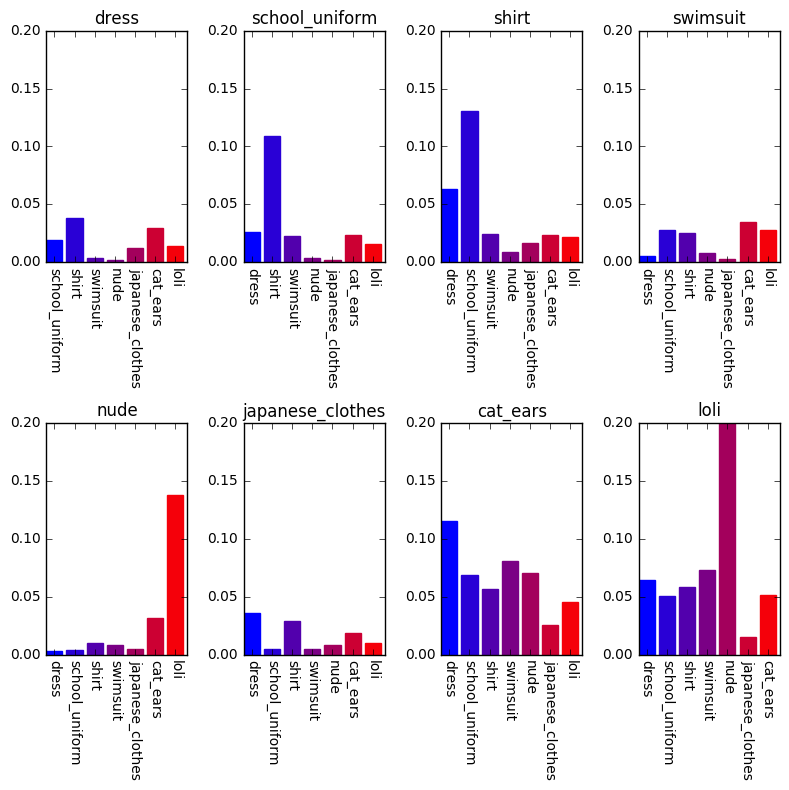

In [26]:
fig = plt.figure(figsize=(len(selected_tags), len(selected_tags)))
for i in range(0, len(selected_tags)):
    ax = fig.add_subplot(2, 4, i + 1)
    bars = ax.bar(range(len(selected_tags) - 1), disjoint_tag_array[i,:] / selected_tag_count[i])
    ax.set_title(tag1[i * (len(selected_tags) - 1)])
    ax.set_xticks(np.arange(len(selected_tags) - 1) + 0.4)
    ax.set_xticklabels(tag2[i * (len(selected_tags) - 1):][:(len(selected_tags) - 1)], rotation=-90)
    ax.set_ylim([0, 0.20])
    r = 0.
    for bar in bars:
        bar.set_color((r, 0, 1 - r))
        r += 0.16
fig.tight_layout()
plt.show()

This is the most important plot of this notebook. Here you can see how many images are tagged with another tag than the main tag. That is bad because I want the sets of images to be as disjoint as possible. (Goal: Categorizing instead of automatic tagging.)

### Results

* The **loli** tag seems to be useless. These lolis wear no clothes.
* The **nude** tag is very nice. Most of the time you can count on its correctness.
* **cat ears** are okayish… But this is only a nice extra so I think it is better to not use this tag.
* **japanese clothes** are nice as well.
* As well as **swim suits**.
* And the **dress** tag is suprisingly disjoint, too.
* As expected the **shirt** tag is the most problematic.
* Directly followed by **school uniform**

Firstly, do not use *loli* for *cat ears* any further.

### What to do now

(You should really read about mathematical notation in Jupyter.)

1. nude' := {nude} - ALL
2. swimsuit' := {swimsuit} - ALL
3. japanese' := {japanese clothes} - {nude} - {swimsuit} - {school uniform}
4. dress' := {dress} - ALL
5. school' := {school uniform} - {dress} - {swimsuit} - {nude} - japanese'
6. shirt' := {shirt} - {nude} - dress' - school' - {swimsuit} - {japanese clothes}

In [27]:
# nude'
cur.execute("CREATE TEMP VIEW IF NOT EXISTS nude_filtered AS "
            "SELECT * FROM nude " +
            "EXCEPT SELECT * FROM dress " +
            "EXCEPT SELECT * FROM school_uniform " +
            "EXCEPT SELECT * FROM shirt " +
            "EXCEPT SELECT * FROM swimsuit " +
            "EXCEPT SELECT * FROM japanese_clothes")

In [28]:
# swimsuit'
cur.execute("CREATE TEMP VIEW IF NOT EXISTS swimsuit_filtered AS "
            "SELECT * FROM swimsuit " +
            "EXCEPT SELECT * FROM dress " +
            "EXCEPT SELECT * FROM school_uniform " +
            "EXCEPT SELECT * FROM shirt " +
            "EXCEPT SELECT * FROM nude " +
            "EXCEPT SELECT * FROM japanese_clothes")

In [29]:
# japanese'
cur.execute("CREATE TEMP VIEW IF NOT EXISTS japanese_filtered AS "
            "SELECT * FROM japanese_clothes " +
            "EXCEPT SELECT * FROM school_uniform " +
            "EXCEPT SELECT * FROM swimsuit " +
            "EXCEPT SELECT * FROM nude")

In [30]:
# dress'
cur.execute("CREATE TEMP VIEW IF NOT EXISTS dress_filtered AS "
            "SELECT * FROM dress " +
            "EXCEPT SELECT * FROM swimsuit " +
            "EXCEPT SELECT * FROM school_uniform " +
            "EXCEPT SELECT * FROM shirt " +
            "EXCEPT SELECT * FROM nude " +
            "EXCEPT SELECT * FROM japanese_clothes")

In [31]:
# 'school
cur.execute("CREATE TEMP VIEW IF NOT EXISTS school_filtered AS "
            "SELECT * FROM school_uniform " +
            "EXCEPT SELECT * FROM dress " +
            "EXCEPT SELECT * FROM swimsuit " +
            "EXCEPT SELECT * FROM nude " +
            "EXCEPT SELECT * FROM japanese_filtered")

In [32]:
# shirt'
cur.execute("CREATE TEMP VIEW IF NOT EXISTS shirt_filtered AS "
            "SELECT * FROM shirt " +
            "EXCEPT SELECT * FROM japanese_clothes " +
            "EXCEPT SELECT * FROM swimsuit " +
            "EXCEPT SELECT * FROM nude " +
            "EXCEPT SELECT * FROM dress_filtered " +
            "EXCEPT SELECT * FROM school_filtered")

In [33]:
filtered_view_names = ("nude_filtered", "swimsuit_filtered", "japanese_filtered",
                       "dress_filtered", "school_filtered", "shirt_filtered")
count_current = []
for name in filtered_view_names:
    cur.execute("SELECT COUNT(*) FROM {}".format(name))
    count_current.append(cur.fetchone()[0])

In [34]:
print("Sum:", sum(count_current))
print("Filter small images with sizes on x or y axis < 200.")
print("Filter images with weird aspect ratio < 2:1.")
count_current_filtered = []
for name in filtered_view_names:
    cur.execute("SELECT COUNT({0}.view) FROM {0} JOIN view ON {0}.view = view.id ".format(name) +
                "WHERE NOT(xsize < 200 or ysize < 200) " +
                "AND (xsize * 1.0) / (ysize * 1.0) >= 0.5 AND (xsize * 1.0) / (ysize * 1.0) <= 2.0")
    count_current_filtered.append(cur.fetchone()[0])
print("Filtered sum:", sum(count_current_filtered))

Sum: 524821
Filter small images with sizes on x or y axis < 200.
Filter images with weird aspect ratio < 2:1.
Filtered sum: 511706


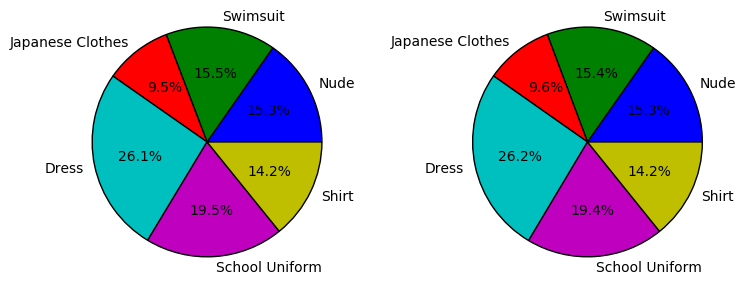

In [36]:
fig = plt.figure(figsize=(9,3))
labels = ["Nude", "Swimsuit", "Japanese Clothes", "Dress", "School Uniform", "Shirt"]
ax1 = fig.add_subplot(121)
ax1.pie(count_current, labels=labels, autopct='%1.1f%%')
ax2 = fig.add_subplot(122)
ax2.pie(count_current_filtered, labels=labels, autopct='%1.1f%%')
ax1.axis("equal")
ax2.axis("equal")
plt.show()

In [44]:
print("{:22}{:10}{:10}".format("", "Tags", "Filtered"))
for i in range(len(count_current)):
    print("{:20}{:10d}{:10d}".format(labels[i], count_current[i], count_current_filtered[i]))

                      Tags      Filtered  
Nude                     80248     78069
Swimsuit                 81329     79023
Japanese Clothes         49831     48883
Dress                   136825    133964
School Uniform          102176     99091
Shirt                    74412     72676
